### **1. Recurrent Neural Network (순환신경망)**

#### Table of Contents
1. RNN 모델 구현 with exmaple
2. LSTM 모델 구현 with example
3. RNN character embedding 나라별 이름 맞추기 예제
4. RNN word embedding 영화 reveiw 예제
5. Machine Translation 예제


### 1. RNN 모델 구현

#### 1-1. RNN과 LSTM 모델 형태 비교

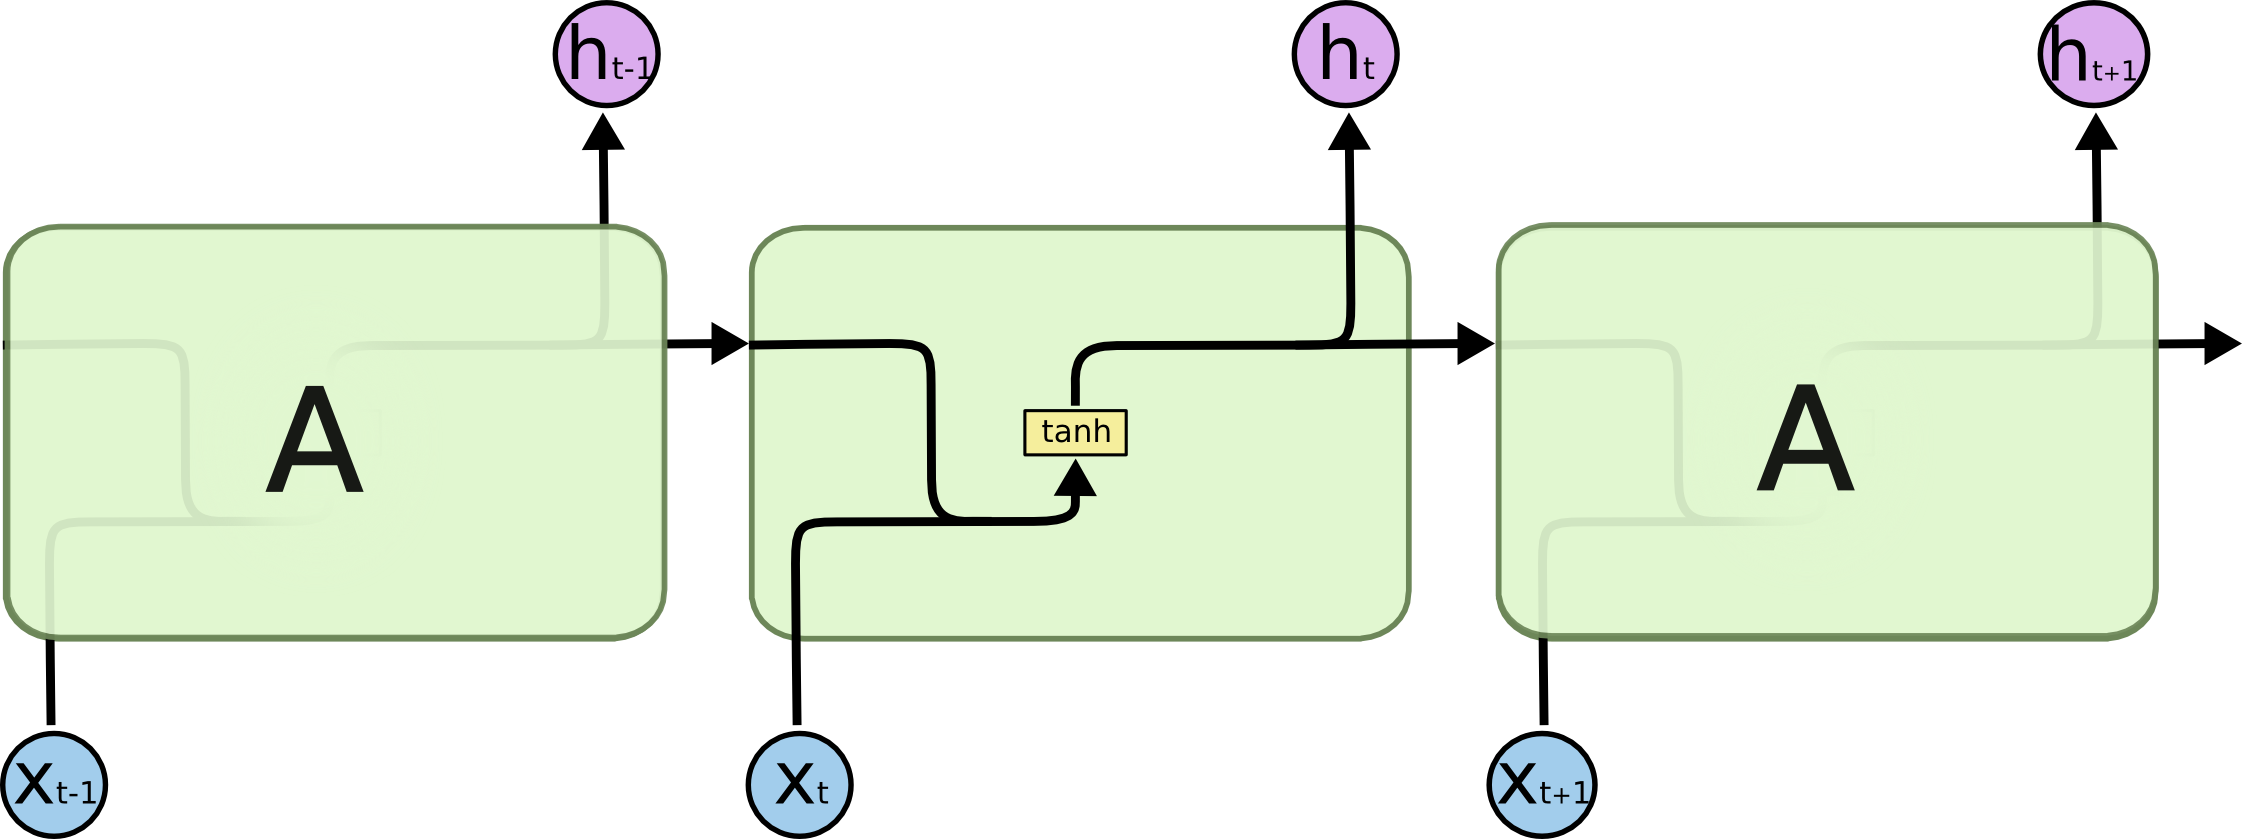

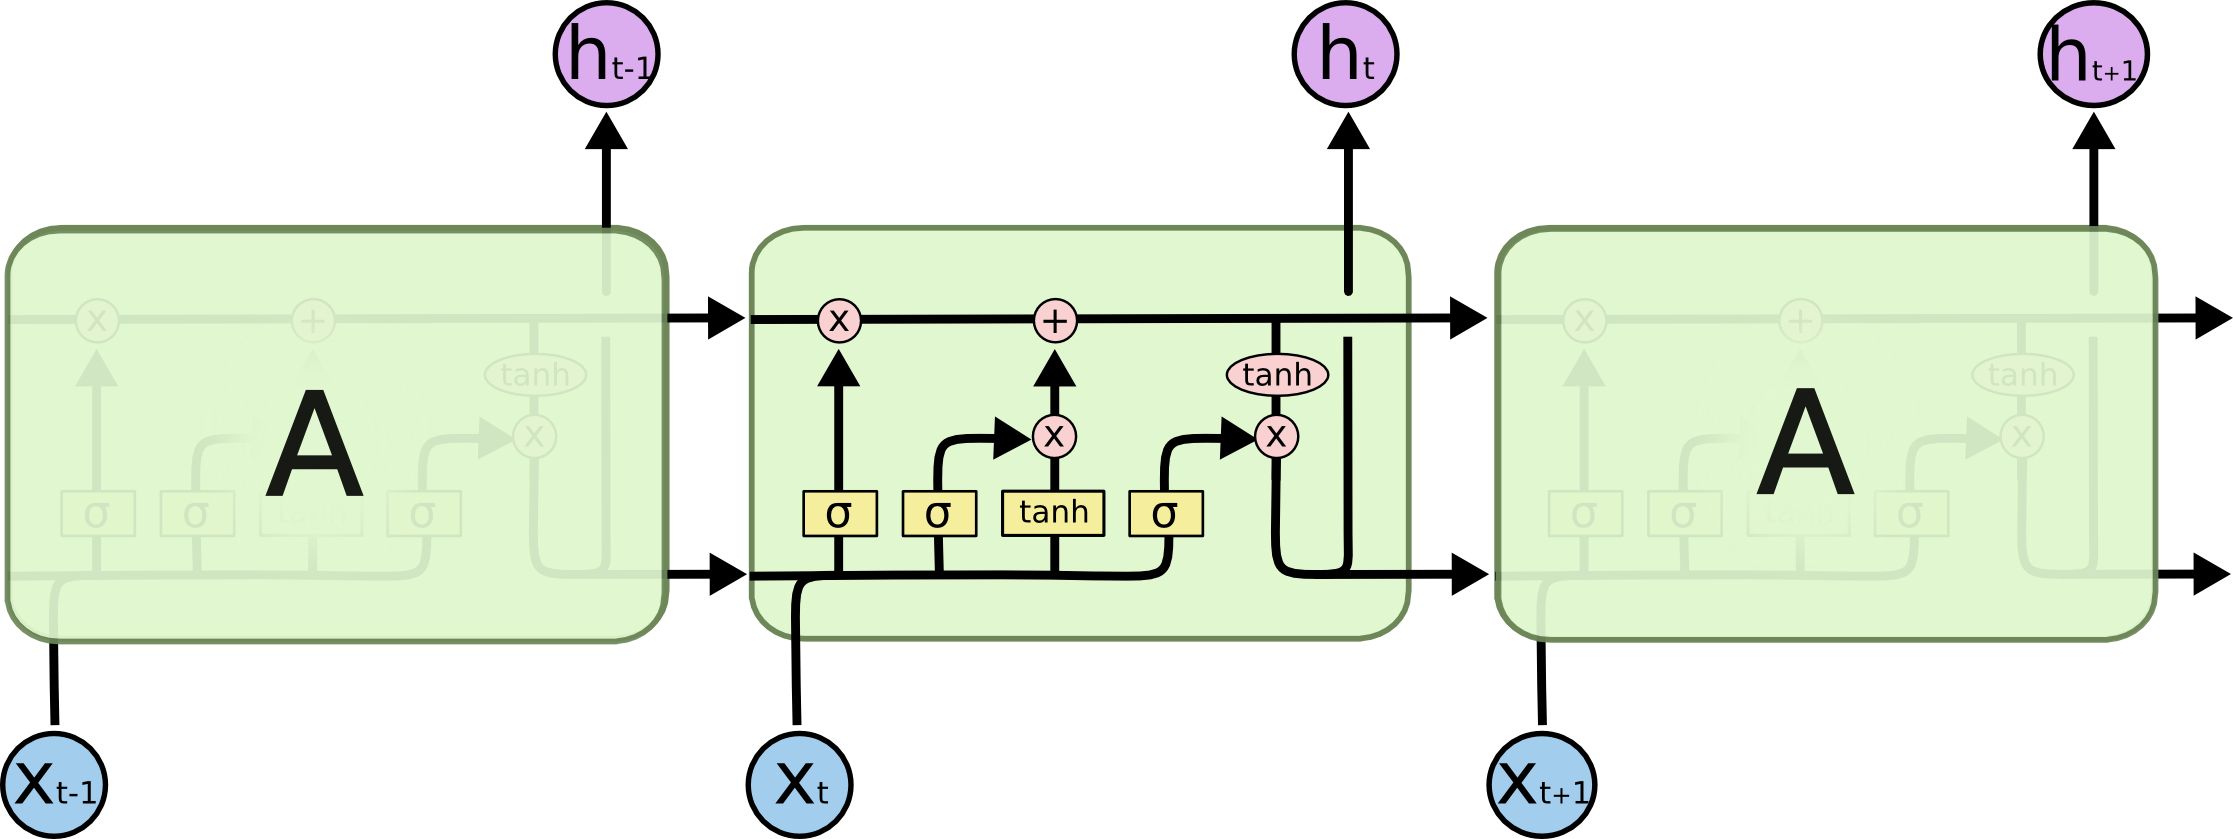

- RNN: recurrent layer를 잇는 가장 단순한 연산만 존재
- LSTM: input gate, output gate, memory gate로 이루어져 정보전달의 허들 존재

#### 1-2. Import required libraries

In [46]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import os 

from tqdm import tqdm
import string
import random
import re
import time, math

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#### 1-3. RNN 함수 구현

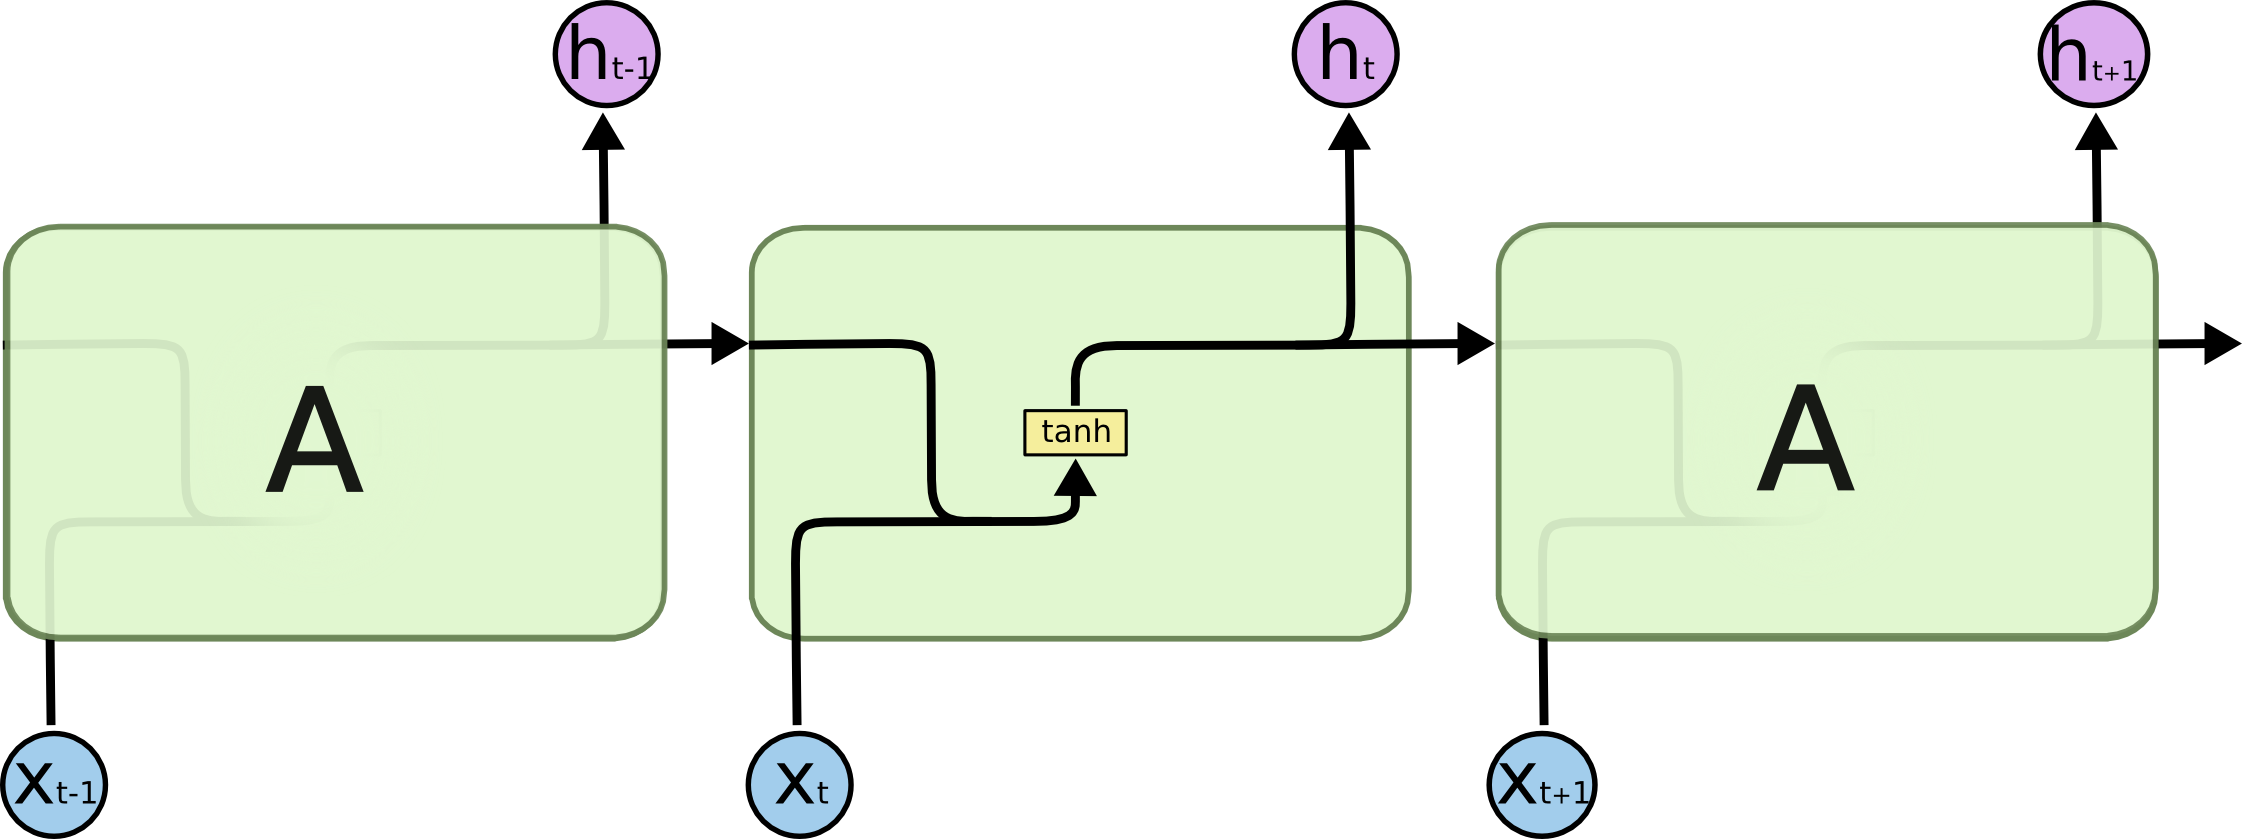

In [47]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.act_fn = nn.Tanh()
    
    def forward(self, input, hidden):
        hidden = self.act_fn(self.i2h(input)+self.h2h(hidden))
        output = self.i2o(hidden)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))  

#### 1-4. Character embedding

- RNN/LSTM이 sequntial 정보를 학습하는 가장 큰 적용 분야가 NLP (Natural Language Processing)
- 사람이 이해할 수 있는 text를 기계가 이해할 수 있는 number/vector 형태로 변환하는 것이 embedding
- Embedding의 종류: Character embedding, Word embedding, Contextual embedding
- **Character Embedding**: 문자 하나하나 단위로 embedding vector로 변환 
- **string_to_onehot**: string을 one-hot vector로 변환
- **onehot_to_word**: one-hot vector를 word(string list)로 변환

In [49]:
# Preprocessing string data
# alphabet(0-25), others(26~32), start(33), end(34) -> 35 chars

chars = "abcdefghijklmnopqrstuvwxyz ?!.,:;01"
char_list = [i for i in chars]
char_len = len(char_list)
n_letters = len(char_list)

# String to onehot vector
# a -> [1 0 0 ... 0 0]

def string_to_onehot(string):
    start = np.zeros(shape=len(char_list) ,dtype=int)
    end = np.zeros(shape=len(char_list) ,dtype=int)
    start[-2] = 1
    end[-1] = 1
    for i in string:
        idx = char_list.index(i)
        zero = np.zeros(shape=char_len ,dtype=int)
        zero[idx]=1
        start = np.vstack([start,zero])
    output = np.vstack([start,end])
    return output

# Onehot vector to word
# [1 0 0 ... 0 0] -> a 

def onehot_to_word(onehot_1):
    out = ''
    for i in range(onehot_1.size(0)):
        onehot = torch.Tensor.numpy(onehot_1[i,:])
        out = out + char_list[onehot.argmax()]
    return out

In [50]:
print(char_len)
string_ = 'ak'
a_onehot = string_to_onehot(string_)
print(a_onehot)
print(np.shape(a_onehot))
a_vec=a_onehot[1:np.shape(a_onehot)[0]-1,:]
a_string = onehot_to_word(torch.Tensor(a_vec))
print(a_string)

35
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
(4, 35)
ak


#### 1-5. Problem settings

- 문장을 따라 배우는 문제를 해결해보자

In [52]:
string_ = "hello pytorch.how long can a rnn cell remember? show us your limit!"

input_size = char_len #length of embedding vector #35
timesteps = 1 # how long a rnn cell would see
hidden_size = 50 # number of hidden neurons
output_size = input_size

lr = 0.01
epochs = 2000

#### 1-6. Loss and optimizer


In [53]:
rnn = RNN(input_size,hidden_size,output_size)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

#### 1-7. Train

In [54]:
one_hot = torch.from_numpy(string_to_onehot(string_)).type_as(torch.FloatTensor())

for i in tqdm(range(epochs)):
    rnn.zero_grad()
    total_loss = 0
    hidden = rnn.init_hidden()

    for j in range(one_hot.size()[0]-1):
        input =  Variable(one_hot[j:j+1,:])### Blank 1 ####
        output, hidden = rnn.forward(input, hidden)
        target =  Variable(one_hot[j+1])#### Blank 2 ####
        loss = loss_func(output.view(-1),target.view(-1))
        total_loss += loss

    total_loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print('Loss: ', total_loss.item())

  1%|          | 11/2000 [00:00<00:39, 50.78it/s]

Loss:  2.811737537384033


  5%|▌         | 107/2000 [00:01<00:35, 53.77it/s]

Loss:  0.08695857971906662


 10%|█         | 209/2000 [00:03<00:32, 54.73it/s]

Loss:  0.028432125225663185


 16%|█▌        | 311/2000 [00:05<00:30, 54.56it/s]

Loss:  0.015761369839310646


 20%|██        | 407/2000 [00:07<00:28, 55.10it/s]

Loss:  0.010877629742026329


 25%|██▌       | 509/2000 [00:09<00:26, 55.68it/s]

Loss:  0.00750393234193325


 31%|███       | 611/2000 [00:11<00:26, 52.64it/s]

Loss:  0.010483036749064922


 35%|███▌      | 707/2000 [00:13<00:23, 54.49it/s]

Loss:  0.0048993900418281555


 40%|████      | 809/2000 [00:14<00:21, 54.22it/s]

Loss:  0.004460267722606659


 46%|████▌     | 911/2000 [00:16<00:20, 53.60it/s]

Loss:  0.0030306330882012844


 50%|█████     | 1007/2000 [00:18<00:18, 54.17it/s]

Loss:  0.0043294718489050865


 55%|█████▌    | 1109/2000 [00:20<00:16, 54.40it/s]

Loss:  0.004949898924678564


 61%|██████    | 1211/2000 [00:22<00:14, 56.30it/s]

Loss:  0.0020649482030421495


 65%|██████▌   | 1307/2000 [00:24<00:12, 54.69it/s]

Loss:  0.0035373400896787643


 70%|███████   | 1409/2000 [00:25<00:10, 54.10it/s]

Loss:  0.0015116180293262005


 76%|███████▌  | 1511/2000 [00:27<00:08, 54.94it/s]

Loss:  0.0061598955653607845


 80%|████████  | 1607/2000 [00:29<00:07, 54.88it/s]

Loss:  0.0013328780187293887


 85%|████████▌ | 1709/2000 [00:31<00:05, 54.39it/s]

Loss:  0.0010972984600812197


 91%|█████████ | 1811/2000 [00:33<00:03, 54.87it/s]

Loss:  0.0010375037090852857


 95%|█████████▌| 1907/2000 [00:35<00:01, 55.34it/s]

Loss:  0.0008034600759856403


100%|██████████| 2000/2000 [00:36<00:00, 54.45it/s]


#### 1-8. Test

In [55]:
hidden = rnn.init_hidden()
input = Variable(one_hot[0:0+timesteps,:])
for i in range(len(string_)):
    output, hidden = rnn.forward(input, hidden)
    
    output_target = output.view(1,-1)
    print(onehot_to_word(output_target.data),end="")#

    input = output_target

hello pytormlerpne cum eepgonno cules leemnrpnus emlemlnr ne lem ce

### 2. LSTM 함수 구축

In [56]:
# Recall the target problem

string_ = "hello pytorch. how long can a rnn cell remember? show me your limit!"
chars = "abcdefghijklmnopqrstuvwxyz ?!.,:;01"
char_list = [i for i in chars]
char_len = len(char_list)
batch_size = 1
seq_len = 1
num_layers = 1
input_size = char_len
hidden_size = 50 
output_size = char_len
lr = 0.01
num_epochs = 2000

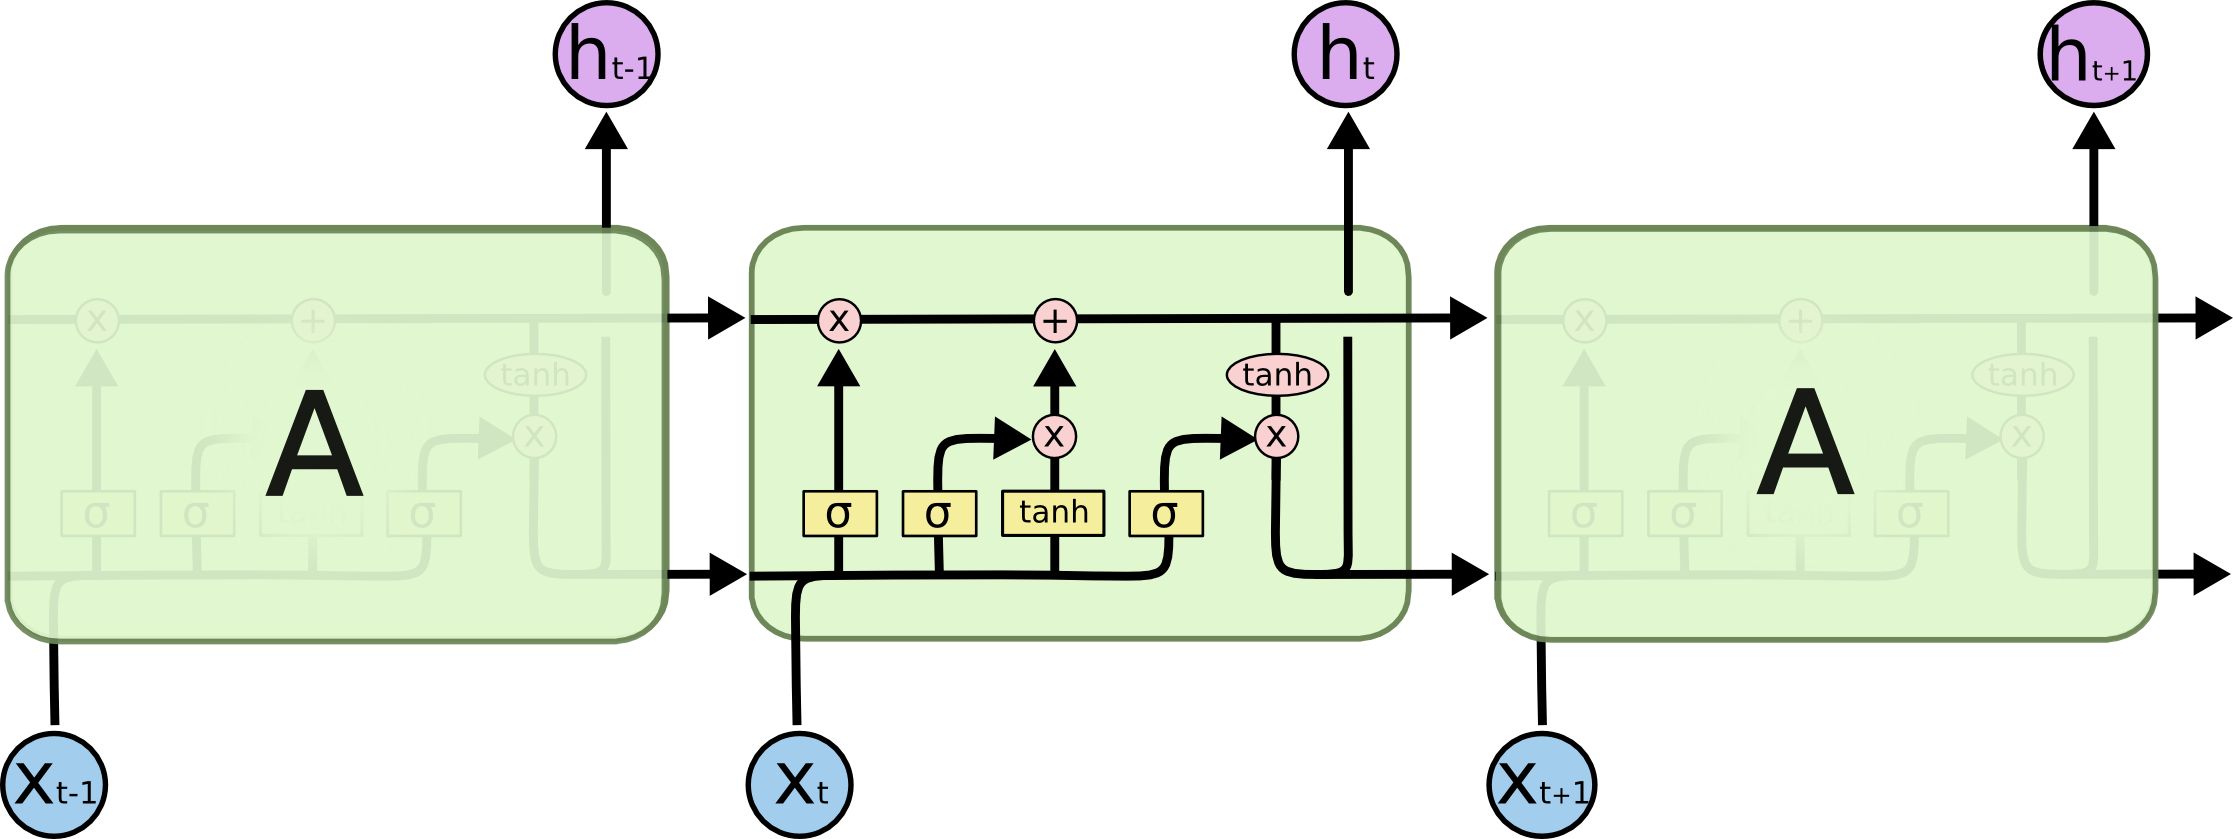

In [58]:
# RNN with 1 hidden layer

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,output_size,num_layers):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers)
        self.h2o = nn.Linear(hidden_size, output_size)
        
    def forward(self,input,hidden,cell):
        ## input data shape: (seq_len, batch_size, input_size)
        ## output data shape: (seq_len, batch_size, hidden_size)
        
        output,(hidden,cell) = self.lstm(input,(hidden,cell))
        output = self.h2o(output[:,-1])
        
        return output,hidden,cell
    
    def init_hidden_cell(self):
        hidden = Variable(torch.zeros(num_layers,batch_size,hidden_size))
        cell = Variable(torch.zeros(num_layers,batch_size,hidden_size))
        
        return hidden,cell
    

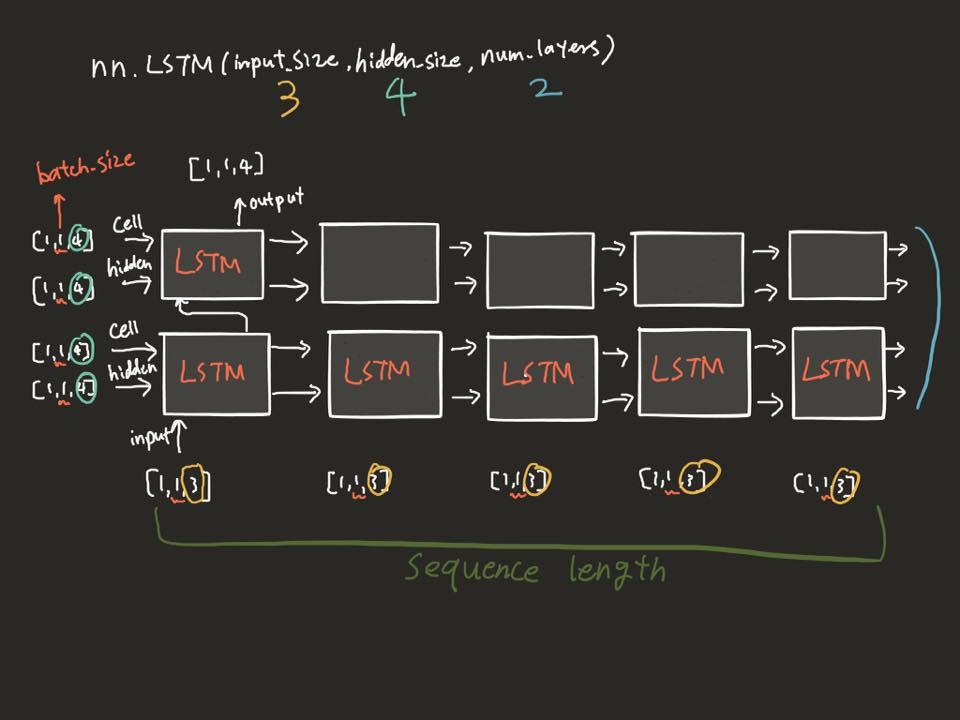

In [59]:
lstm = LSTM(input_size,hidden_size,output_size,num_layers)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)

In [60]:
one_hot = torch.from_numpy(string_to_onehot(string_)).type_as(torch.FloatTensor())
print(one_hot.size())

j=0
input_data = Variable(one_hot[j:j+seq_len].view(batch_size,seq_len,-1))
print(input_data.size())

hidden,cell = lstm.init_hidden_cell()
print(hidden.size(),cell.size())

output, hidden,cell = lstm(input_data,hidden,cell)
print(output.size(),hidden.size(),cell.size())

torch.Size([70, 35])
torch.Size([1, 1, 35])
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 35]) torch.Size([1, 1, 50]) torch.Size([1, 1, 50])


In [61]:
unroll_len = one_hot.size()[0]//seq_len -1

for i in tqdm(range(num_epochs)):
    lstm.zero_grad()
    total_loss = 0
    hidden,cell = lstm.init_hidden_cell()
    
    for j in range(unroll_len):
        input_data = Variable(one_hot[j:j+seq_len].view(seq_len,batch_size,-1))### Blank 3 ####
        output, hidden, cell = lstm(input_data,hidden,cell)

        label = Variable(one_hot[j+1:j+seq_len+1].view(batch_size,-1))### Blank 4 ####
        
        loss = loss_func(output.view(1,-1),label.view(1,-1))

        total_loss += loss

    total_loss.backward()
    optimizer.step()

    if i%100 ==0:
        print(total_loss.item())

  0%|          | 6/2000 [00:00<01:14, 26.74it/s]

2.428269863128662


  5%|▌         | 105/2000 [00:03<01:11, 26.57it/s]

0.059607941657304764


 10%|█         | 204/2000 [00:07<01:04, 27.92it/s]

0.002658634912222624


 15%|█▌        | 306/2000 [00:10<00:59, 28.28it/s]

0.00013138055510353297


 20%|██        | 405/2000 [00:14<00:57, 27.92it/s]

1.9665721993078478e-05


 25%|██▌       | 504/2000 [00:18<00:52, 28.24it/s]

1.9315672034281306e-05


 30%|███       | 606/2000 [00:21<00:51, 26.92it/s]

3.1787487387191504e-05


 35%|███▌      | 705/2000 [00:25<00:48, 26.89it/s]

2.348879661440151e-06


 40%|████      | 804/2000 [00:29<00:43, 27.72it/s]

1.2492143923736876e-06


 45%|████▌     | 906/2000 [00:32<00:40, 27.16it/s]

2.7495843823999166e-05


 50%|█████     | 1005/2000 [00:36<00:35, 27.66it/s]

8.266361874120776e-06


 55%|█████▌    | 1104/2000 [00:39<00:31, 28.18it/s]

6.064326498744776e-07


 60%|██████    | 1206/2000 [00:43<00:28, 27.76it/s]

2.0032750853715697e-06


 65%|██████▌   | 1305/2000 [00:47<00:25, 27.20it/s]

7.715705578448251e-06


 70%|███████   | 1404/2000 [00:50<00:21, 28.37it/s]

0.00018058271962217987


 75%|███████▌  | 1506/2000 [00:54<00:17, 28.41it/s]

5.968000095890602e-06


 80%|████████  | 1605/2000 [00:57<00:14, 27.85it/s]

8.310417797474656e-06


 85%|████████▌ | 1704/2000 [01:01<00:10, 28.24it/s]

1.5255770904332167e-06


 90%|█████████ | 1806/2000 [01:05<00:07, 27.46it/s]

1.4887496035953518e-06


 95%|█████████▌| 1905/2000 [01:08<00:03, 28.22it/s]

1.0431456303194864e-06


100%|██████████| 2000/2000 [01:12<00:00, 27.73it/s]


In [62]:
hidden,cell = lstm.init_hidden_cell()
input_data = Variable(one_hot[0:0+seq_len].view(batch_size,seq_len,-1))

for j in range(unroll_len-1):
    
    output, hidden, cell = lstm(input_data,hidden,cell)
    
    print(onehot_to_word(output.data),end="")

    input_data = output.view(batch_size,seq_len,-1)

hello pytorch. how long can a rnn cell remember? show me your limit!

### 3. nn.Embedding for reference

Embedding을 사용하면 one-hot vector를 사용하지 않아도 됨

In [63]:
a = Variable(torch.LongTensor([0,0,0,1]))
b = Variable(torch.LongTensor([3]))

a_ = Variable(torch.LongTensor([[0,0,0,1],[1,0,0,0],[0,1,0,0],[0,0,1,0]]))
b_ = Variable(torch.LongTensor([3,0,1,2]))


embedder = nn.Embedding(num_embeddings=4,embedding_dim=5)

embedder(a).size(), embedder(b).size(), embedder(a_).size(), embedder(b_).size()

(torch.Size([4, 5]),
 torch.Size([1, 5]),
 torch.Size([4, 4, 5]),
 torch.Size([4, 5]))

### 4. Character Embedding another example

- 나라별 first name이 주어질 때 어느 나라 이름인지 맞추는 문제를 해결해보자

In [65]:
if not os.path.exists('data'):
  !wget https://download.pytorch.org/tutorial/data.zip
  !unzip data.zip

In [66]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/French.txt', 'data/names/English.txt', 'data/names/Russian.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/Greek.txt', 'data/names/Czech.txt', 'data/names/Irish.txt', 'data/names/Vietnamese.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt', 'data/names/Italian.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Spanish.txt']
Slusarski


In [67]:
print(all_letters)
print(len(all_letters))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


In [68]:
print(category_lines['Italian'][:5])
print(category_lines['Korean'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


In [69]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [70]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [71]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [72]:
input = letterToTensor('A')
hidden =torch.zeros((1, n_hidden))

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.8180, -2.9104, -2.8976, -2.8079, -2.7978, -2.8763, -2.9838, -2.8822,
         -2.8389, -2.9336, -2.9836, -2.9250, -2.9917, -2.9913, -2.8167, -2.8578,
         -2.8337, -2.9179]], grad_fn=<LogSoftmaxBackward>)


In [73]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8180, -2.9104, -2.8976, -2.8079, -2.7978, -2.8763, -2.9838, -2.8822,
         -2.8389, -2.9336, -2.9836, -2.9250, -2.9917, -2.9913, -2.8167, -2.8578,
         -2.8337, -2.9179]], grad_fn=<LogSoftmaxBackward>)


In [76]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 4)


In [77]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Manoukarakis
category = Czech / line = Rebka
category = Polish / line = Jez
category = Chinese / line = Hew
category = Japanese / line = Akamatsu
category = French / line = David
category = Portuguese / line = D'cruz
category = Chinese / line = Sui
category = Irish / line = Neville
category = Vietnamese / line = Phi


In [78]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [79]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

for iter in tqdm(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  5%|▌         | 5113/100000 [00:06<02:06, 752.79it/s]

5000 5% 2.1950 Sada / Japanese ✓


 10%|█         | 10118/100000 [00:13<02:11, 683.70it/s]

10000 10% 2.1944 Aritza / Japanese ✗ (Spanish)


 15%|█▌        | 15117/100000 [00:20<01:56, 729.53it/s]

15000 15% 0.1626 Panayiotopoulos / Greek ✓


 20%|██        | 20088/100000 [00:27<01:45, 755.32it/s]

20000 20% 0.8374 Moon / Korean ✓


 25%|██▌       | 25139/100000 [00:34<01:40, 745.10it/s]

25000 25% 1.1547 Robertson / Scottish ✓


 30%|███       | 30114/100000 [00:40<01:38, 706.90it/s]

30000 30% 1.3570 Bitar / Arabic ✓


 35%|███▌      | 35102/100000 [00:47<01:22, 784.25it/s]

35000 35% 1.8407 Crespo / Portuguese ✗ (Spanish)


 40%|████      | 40083/100000 [00:54<01:21, 736.51it/s]

40000 40% 2.5218 Rettig / Scottish ✗ (German)


 45%|████▌     | 45089/100000 [01:00<01:19, 686.74it/s]

45000 45% 3.1234 Tsigler / German ✗ (Russian)


 50%|█████     | 50128/100000 [01:07<01:05, 763.57it/s]

50000 50% 1.8171 Rong / Korean ✗ (Chinese)


 55%|█████▌    | 55102/100000 [01:14<00:59, 756.43it/s]

55000 55% 0.4700 Rodrigues / Portuguese ✓


 60%|██████    | 60106/100000 [01:20<00:52, 756.34it/s]

60000 60% 3.7641 Lihodei / Italian ✗ (Russian)


 65%|██████▌   | 65133/100000 [01:27<00:46, 750.89it/s]

65000 65% 0.4307 Dam / Vietnamese ✓


 70%|███████   | 70104/100000 [01:34<00:40, 735.04it/s]

70000 70% 1.3974 Morton / Scottish ✗ (English)


 75%|███████▌  | 75086/100000 [01:40<00:33, 748.49it/s]

75000 75% 0.2000 Vu / Vietnamese ✓


 80%|████████  | 80084/100000 [01:47<00:26, 754.38it/s]

80000 80% 0.2910 Jang / Korean ✓


 85%|████████▌ | 85091/100000 [01:54<00:19, 754.19it/s]

85000 85% 0.3059 Yu / Korean ✓


 90%|█████████ | 90141/100000 [02:01<00:13, 733.12it/s]

90000 90% 0.0334 Karkampasis / Greek ✓


 95%|█████████▌| 95085/100000 [02:07<00:06, 747.32it/s]

95000 95% 2.3651 Egr / German ✗ (Czech)


100%|██████████| 100000/100000 [02:14<00:00, 744.53it/s]

100000 100% 0.2185 O'Dowd / Irish ✓


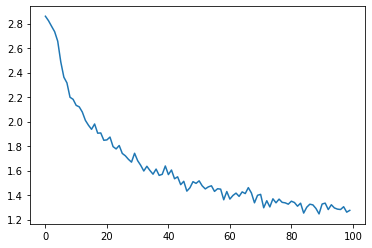

In [80]:
plt.figure()
plt.plot(all_losses)

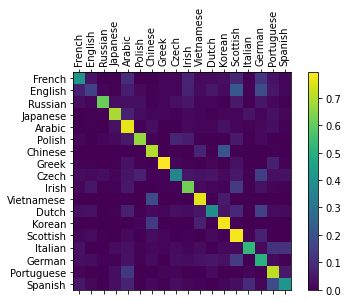

In [81]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [82]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [83]:
predict('Dovesky') ##Czech
predict('Jackson') #Scottish
predict('Satoshi') ##Japanese
predict('Kim') ##Koream
predict('Chen') ##Chinese
predict('Collins') ##Irish
predict('Akita') ##Japanese
predict('Phan') ##Vietnamese


> Dovesky
(-0.78) Czech
(-1.01) Russian
(-2.80) Polish

> Jackson
(-0.79) Scottish
(-1.23) English
(-2.56) Russian

> Satoshi
(-0.18) Arabic
(-3.09) Polish
(-3.25) Japanese

> Kim
(-0.43) Korean
(-1.56) Chinese
(-3.05) Vietnamese

> Chen
(-0.80) Korean
(-1.20) Chinese
(-2.71) Vietnamese

> Collins
(-1.30) Greek
(-1.67) English
(-1.94) French

> Akita
(-0.91) Japanese
(-1.68) Czech
(-2.38) Dutch

> Phan
(-0.57) Vietnamese
(-1.48) Chinese
(-2.72) Irish


## References

1) https://github.com/GunhoChoi/PyTorch-FastCampus/tree/master/05_RNN

2) https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html